# Multilayer Neural Networks for Nonlinear Regression


## Optimizers

First, we need a class that includes our optimization algorithms, `sgd` and `adam`.  The following code cell implements `sgd`.

Notice that `all_weights` is updated in place by these optimization algorithms.  The new values of `all_weights` are not returned from these functions, because the code that calls these functions allocates the memory for `all_weights` and keeps the reference to it so has direct access to the new values.

In [36]:
import numpy as np
import matplotlib.pyplot as plt

In [37]:
class Optimizers():

    def __init__(self, all_weights):
        '''all_weights is a vector of all of a neural networks weights concatenated into a one-dimensional vector'''
        
        self.all_weights = all_weights

        # The following initializations are only used by adam.
        # Only initializing mt, vt, beta1t and beta2t here allows multiple calls to adam to handle training
        # with multiple subsets (batches) of training data.
        self.mt = np.zeros_like(all_weights)
        self.vt = np.zeros_like(all_weights)
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.beta1t = 1  # was self.beta1
        self.beta2t = 1  # was self.beta2

        
    def sgd(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            # Update all weights using -= to modify their values in-place.
            self.all_weights -= learning_rate * grad

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'sgd: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

    def adam(self, error_f, gradient_f, fargs=[], n_epochs=100, learning_rate=0.001, error_convert_f=None):
        '''
        error_f: function that requires X and T as arguments (given in fargs) and returns mean squared error.
        gradient_f: function that requires X and T as arguments (in fargs) and returns gradient of mean squared error
                    with respect to each weight.
        error_convert_f: function that converts the standardized error from error_f to original T units.
        '''

        alpha = learning_rate  # learning rate called alpha in original paper on adam
        epsilon = 1e-8
        error_trace = []
        epochs_per_print = n_epochs // 10

        for epoch in range(n_epochs):

            error = error_f(*fargs)
            grad = gradient_f(*fargs)

            self.mt = self.beta1 * self.mt + (1 - self.beta1) * grad
            self.vt = self.beta2 * self.vt + (1 - self.beta2) * np.square(grad)
            
            self.beta1t *= self.beta1
            self.beta2t *= self.beta2
            
            mhat = self.mt / (1 - self.beta1t)
            vhat = self.vt / (1 - self.beta2t)
            
            self.all_weights -= alpha * mhat / (np.sqrt(vhat) + epsilon)

            if error_convert_f:
                error = error_convert_f(error)
            error_trace.append(error)

            if (epoch + 1) % max(1, epochs_per_print) == 0:
                print(f'Adam: Epoch {epoch+1:d} Error={error:.5f}')

        return error_trace

Test `Optimizers` using the function `test_optimizers`. 

In [38]:
def test_optimizers():

    def parabola(wmin):
        return ((w - wmin) ** 2)[0]

    def parabola_gradient(wmin):
        return 2 * (w - wmin)

    w = np.array([0.0])
    optimizer = Optimizers(w)

    wmin = 5
    optimizer.sgd(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'sgd: Minimum of parabola is at {wmin}. Value found is {w}')

    w = np.array([0.0])
    optimizer = Optimizers(w)
    optimizer.adam(parabola, parabola_gradient, [wmin], n_epochs=100, learning_rate=0.1)
    print(f'adam: Minimum of parabola is at {wmin}. Value found is {w}')

In [39]:
test_optimizers()

sgd: Epoch 10 Error=0.45036
sgd: Epoch 20 Error=0.00519
sgd: Epoch 30 Error=0.00006
sgd: Epoch 40 Error=0.00000
sgd: Epoch 50 Error=0.00000
sgd: Epoch 60 Error=0.00000
sgd: Epoch 70 Error=0.00000
sgd: Epoch 80 Error=0.00000
sgd: Epoch 90 Error=0.00000
sgd: Epoch 100 Error=0.00000
sgd: Minimum of parabola is at 5. Value found is [5.]
Adam: Epoch 10 Error=16.85565
Adam: Epoch 20 Error=9.93336
Adam: Epoch 30 Error=5.21627
Adam: Epoch 40 Error=2.37740
Adam: Epoch 50 Error=0.90515
Adam: Epoch 60 Error=0.26972
Adam: Epoch 70 Error=0.05453
Adam: Epoch 80 Error=0.00453
Adam: Epoch 90 Error=0.00016
Adam: Epoch 100 Error=0.00147
adam: Minimum of parabola is at 5. Value found is [5.03900403]


## NeuralNetwork class

Now we can implement the `NeuralNetwork` class that calls the above `Optimizers` functions to update the weights.

In [40]:
class NeuralNetwork():
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):
        '''
        train: 
        X: n_samples x n_inputs matrix of input samples, one per row
        T: n_samples x n_outputs matrix of target output values, one sample per row
        n_epochs: number of passes to take through all samples updating weights each pass
        learning_rate: factor controlling the step size of each update
        method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        self.Ys = [X]
        for W in self.Ws[:-1]:
            self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
        last_W = self.Ws[-1]
        self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
        return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction'''
        X_std = (X - self.Xmeans) / self.Xstds
        YtestS = self.forward_pass(X_std)
        Y = YtestS[3] * self.Tstds + self.Tmeans
        return Y

Then test it with the `test_neuralnetwork` function.

In [41]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [42]:
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.06879627, -0.0688011 ],
       [-0.08838328,  0.07323523]])

In [43]:
np.random.seed(42)
np.random.uniform(-0.1, 0.1, size=(2, 2))

array([[-0.02509198,  0.09014286],
       [ 0.04639879,  0.0197317 ]])

In [44]:
def test_neuralnetwork():
    
    np.random.seed(42)
    
    X = np.arange(100).reshape((-1, 1))
    T = np.sin(X * 0.04)

    n_hiddens = [10, 10]
    n_epochs = 2000
    learning_rate = 0.01
    
    nnetsgd = NeuralNetwork(1, n_hiddens, 1)
    nnetsgd.train(X, T, n_epochs, learning_rate, method='sgd')

    print()  # skip a line
    
    nnetadam = NeuralNetwork(1, n_hiddens, 1)
    nnetadam.train(X, T, n_epochs, learning_rate, method='adam')

    Ysgd = nnetsgd.use(X)
    Yadam = nnetadam.use(X)

    plt.figure(figsize=(15,10))
    plt.subplot(1, 3, 1)
    plt.plot(nnetsgd.error_trace, label='SGD')
    plt.plot(nnetadam.error_trace, label='Adam')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(T, Ysgd, 'o', label='SGD')
    plt.plot(T, Yadam, 'o', label='Adam')
    a = min(np.min(T), np.min(Ysgd))
    b = max(np.max(T), np.max(Ysgd))
    plt.plot([a, b], [a, b], 'k-', lw=3, alpha=0.5, label='45 degree')
    plt.xlabel('Target')
    plt.ylabel('Predicted')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(Ysgd, 'o-', label='SGD')
    plt.plot(Yadam, 'o-', label='Adam')
    plt.plot(T, label='Target')
    plt.xlabel('Sample')
    plt.ylabel('Target or Predicted')
    plt.legend()

    plt.tight_layout()

sgd: Epoch 200 Error=0.49330
sgd: Epoch 400 Error=0.46833
sgd: Epoch 600 Error=0.44525
sgd: Epoch 800 Error=0.42264
sgd: Epoch 1000 Error=0.39428
sgd: Epoch 1200 Error=0.35526
sgd: Epoch 1400 Error=0.30300
sgd: Epoch 1600 Error=0.24079
sgd: Epoch 1800 Error=0.18020
sgd: Epoch 2000 Error=0.13423

Adam: Epoch 200 Error=0.11620
Adam: Epoch 400 Error=0.00795
Adam: Epoch 600 Error=0.00362
Adam: Epoch 800 Error=0.00268
Adam: Epoch 1000 Error=0.00236


Adam: Epoch 1200 Error=0.00213
Adam: Epoch 1400 Error=0.00200
Adam: Epoch 1600 Error=0.00183
Adam: Epoch 1800 Error=0.00691
Adam: Epoch 2000 Error=0.00163


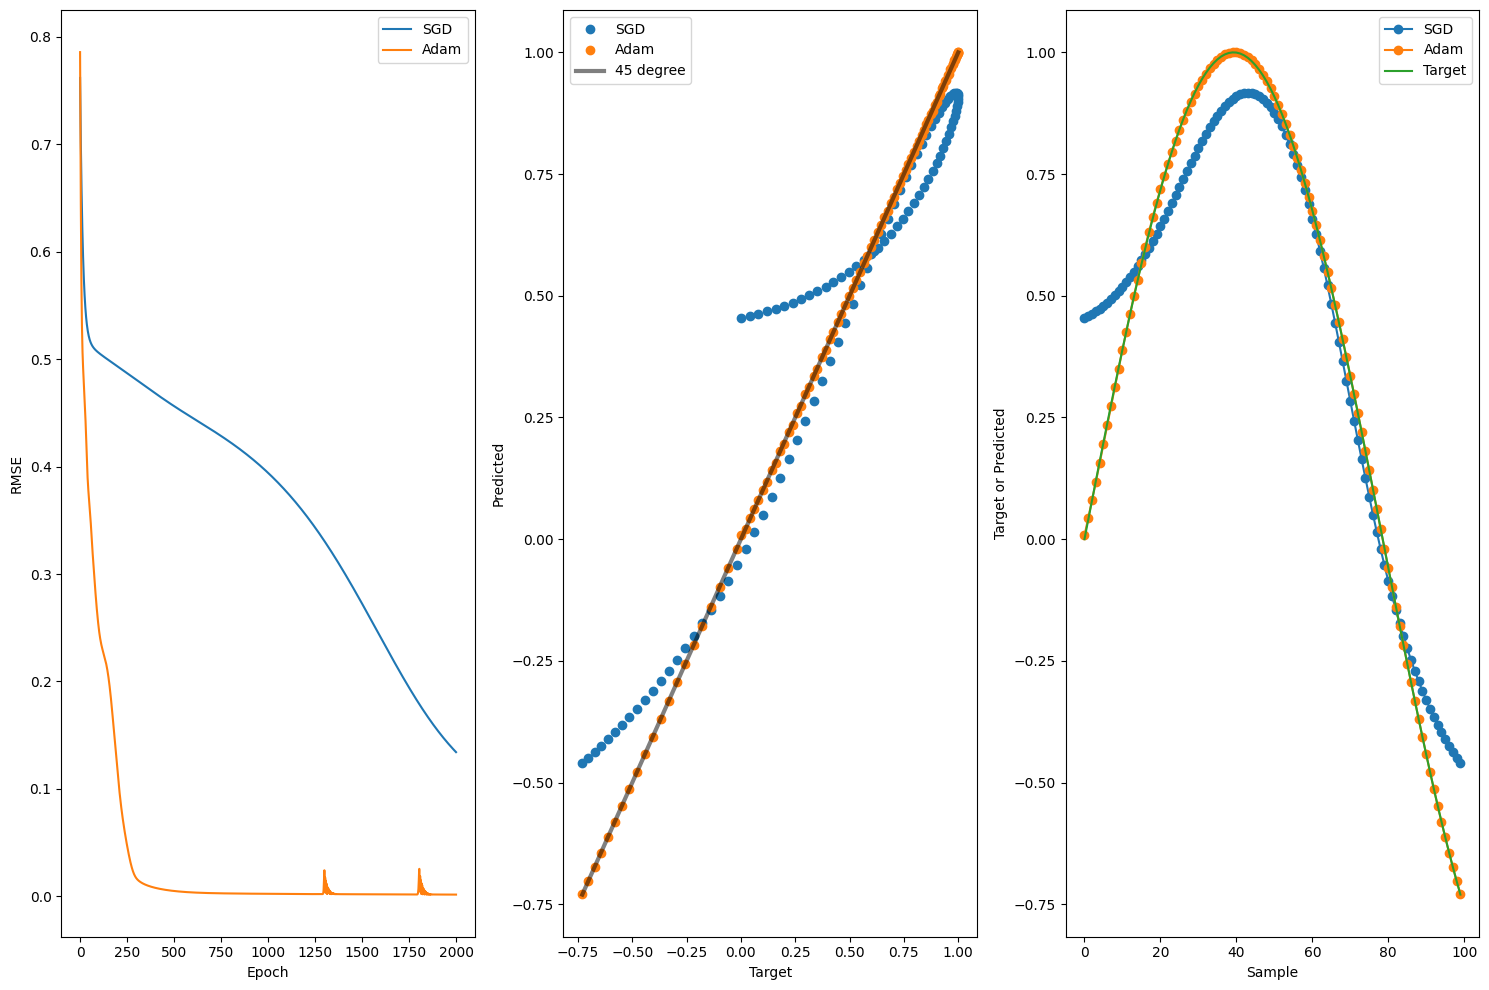

In [45]:
test_neuralnetwork()

## ReLU Activation Function

Modify the NeuralNetwork class to allow the use of the ReLU activiation function, in addition to the `tanh` activation function that `NeuralNetwork` currently uses.  

Do this by
* Add the argument `activation_function` to the `NeuralNetwork` constructor that can be given values of `tanh` or `relu`, with `tanh` being its default value.
* Define two new class functions, `relu(s)` that accepts a matrix of weighted sums and returns the ReLU values, and `grad_relu(s)` that returns the gradient of `relu(s)` with respect to each value in `s`.
* Add `if` statements to `forward_pass` and `gradient_f` to selectively use the `tanh` or `relu` activation function. This is easy if you assign a new class variable in the `NeuralNetwork` constructor that has the value of the argument `activation_function`.

In [46]:
class NeuralNetwork():
    def __init__(self, n_inputs, n_hiddens_per_layer, n_outputs, activation_function='tanh'):
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.activaton = activation_function

        # Set self.n_hiddens_per_layer to [] if argument is 0, [], or [0]
        if n_hiddens_per_layer == 0 or n_hiddens_per_layer == [] or n_hiddens_per_layer == [0]:
            self.n_hiddens_per_layer = []
        else:
            self.n_hiddens_per_layer = n_hiddens_per_layer

        # Initialize weights, by first building list of all weight matrix shapes.
        n_in = n_inputs
        shapes = []
        for nh in self.n_hiddens_per_layer:
            shapes.append((n_in + 1, nh))
            n_in = nh
        shapes.append((n_in + 1, n_outputs))

        # self.all_weights:  vector of all weights
        # self.Ws: list of weight matrices by layer
        self.all_weights, self.Ws = self.make_weights_and_views(shapes)

        # Define arrays to hold gradient values.
        # One array for each W array with same shape.
        self.all_gradients, self.dE_dWs = self.make_weights_and_views(shapes)

        self.trained = False
        self.total_epochs = 0
        self.error_trace = []
        self.Xmeans = None
        self.Xstds = None
        self.Tmeans = None
        self.Tstds = None


    def make_weights_and_views(self, shapes):
        # vector of all weights built by horizontally stacking flatenned matrices
        # for each layer initialized with uniformly-distributed values.
        all_weights = np.hstack([np.random.uniform(size=shape).flat / np.sqrt(shape[0])
                                 for shape in shapes])
        # Build list of views by reshaping corresponding elements from vector of all weights
        # into correct shape for each layer.
        views = []
        start = 0
        for shape in shapes:
            size =shape[0] * shape[1]
            views.append(all_weights[start:start + size].reshape(shape))
            start += size
        return all_weights, views


    # Return string that shows how the constructor was called
    def __repr__(self):
        return f'NeuralNetwork({self.n_inputs}, {self.n_hiddens_per_layer}, {self.n_outputs})'


    # Return string that is more informative to the user about the state of this neural network.
    def __str__(self):
        if self.trained:
            return self.__repr__() + f' trained for {self.total_epochs} epochs, final training error {self.error_trace[-1]}'


    def train(self, X, T, n_epochs, learning_rate, method='sgd'):
        '''
        train: 
        X: n_samples x n_inputs matrix of input samples, one per row
        T: n_samples x n_outputs matrix of target output values, one sample per row
        n_epochs: number of passes to take through all samples updating weights each pass
        learning_rate: factor controlling the step size of each update
        method: is either 'sgd' or 'adam'
        '''

        # Setup standardization parameters
        if self.Xmeans is None:
            self.Xmeans = X.mean(axis=0)
            self.Xstds = X.std(axis=0)
            self.Xstds[self.Xstds == 0] = 1  # So we don't divide by zero when standardizing
            self.Tmeans = T.mean(axis=0)
            self.Tstds = T.std(axis=0)
            
        # Standardize X and T
        X = (X - self.Xmeans) / self.Xstds
        T = (T - self.Tmeans) / self.Tstds

        # Instantiate Optimizers object by giving it vector of all weights
        optimizer = Optimizers(self.all_weights)

        # Define function to convert value from error_f into error in original T units.
        error_convert_f = lambda err: (np.sqrt(err) * self.Tstds)[0] # to scalar

        if method == 'sgd':

            error_trace = optimizer.sgd(self.error_f, self.gradient_f,
                                        fargs=[X, T], n_epochs=n_epochs,
                                        learning_rate=learning_rate,
                                        error_convert_f=error_convert_f)

        elif method == 'adam':

            error_trace = optimizer.adam(self.error_f, self.gradient_f,
                                         fargs=[X, T], n_epochs=n_epochs,
                                         learning_rate=learning_rate,
                                         error_convert_f=error_convert_f)

        else:
            raise Exception("method must be 'sgd' or 'adam'")
        
        self.error_trace = error_trace

        # Return neural network object to allow applying other methods after training.
        #  Example:    Y = nnet.train(X, T, 100, 0.01).use(X)
        return self

   
    def forward_pass(self, X):
        '''X assumed already standardized. Output returned as standardized.'''
        if self.activaton == 'tanh':
            self.Ys = [X]
            for W in self.Ws[:-1]:
                self.Ys.append(np.tanh(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            last_W = self.Ws[-1]
            self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
            return self.Ys
        elif self.activaton == 'relu':
            self.Ys = [X]
            for W in self.Ws[:-1]:
                self.Ys.append(self.relu(self.Ys[-1] @ W[1:, :] + W[0:1, :]))
            last_W = self.Ws[-1]
            self.Ys.append(self.Ys[-1] @ last_W[1:, :] + last_W[0:1, :])
            return self.Ys

    # Function to be minimized by optimizer method, mean squared error
    def error_f(self, X, T):
        Ys = self.forward_pass(X)
        mean_sq_error = np.mean((T - Ys[-1]) ** 2)
        return mean_sq_error

    # Gradient of function to be minimized for use by optimizer method
    def gradient_f(self, X, T):
        '''Assumes forward_pass just called with layer outputs in self.Ys.'''
        error = T - self.Ys[-1]
        n_samples = X.shape[0]
        n_outputs = T.shape[1]
        delta = - error / (n_samples * n_outputs)
        n_layers = len(self.n_hiddens_per_layer) + 1
        # Step backwards through the layers to back-propagate the error (delta)
        for layeri in range(n_layers - 1, -1, -1):
            # gradient of all but bias weights
            self.dE_dWs[layeri][1:, :] = self.Ys[layeri].T @ delta
            # gradient of just the bias weights
            self.dE_dWs[layeri][0:1, :] = np.sum(delta, 0)
            # Back-propagate this layer's delta to previous layer
            
            if self.activaton == 'tanh':
                delta = delta @ self.Ws[layeri][1:, :].T * (1 - self.Ys[layeri] ** 2)
            elif self.activaton == 'relu':
                relu_d = self.grad_relu(self.Ys[layeri])
                delta = delta @ self.Ws[layeri][1:, :].T * relu_d 
        return self.all_gradients

    def use(self, X):
        '''X assumed to not be standardized. Return the unstandardized prediction'''
        X_std = (X - self.Xmeans) / self.Xstds
        YtestS = self.forward_pass(X_std)
        Y = YtestS[-1] * self.Tstds + self.Tmeans
        return Y
    
    def relu(self, S):
        Y = S.copy()
        Y[Y < 0] = 0
        return Y

    def grad_relu(self, S):
        dY = S.copy()
        dY[dY < 0] = 0 
        dY[dY > 0] = 1
        dY[dY == 0] = 0
        return dY

Now, let's apply it to some interesting data.
This time we will partition the data into five parts after randomly rearranging the samples.  We will assign the first partition as the validation set, the second one as the test set, and the remaining parts will be vertically stacked to form the training set, as discussed in lecture.  We can use the RMSE on the validation set to pick the best values of the number of epochs and the network architecture.  Then to report on the RMSE we expect on new data, we will report the test set RMSE.

Read in the `auto-mpg.data` using `pandas` and remove all samples that contain missing values.  You should end up with 392 samples.

Now randomly reorder the samples.  First run `np.random.seed(42)` to guarantee that we all use the same random ordering of samples.

Partition the data into five folds, as shown in lecture.  To do this, complete the following function.

In [47]:
import pandas as pd
X = pd.read_csv('auto-mpg.data-original', header=None, delim_whitespace=True, na_values='?')
X = X.dropna()
X = X.iloc[:, :-1].values # view everything except the car names (last column)

T = X[:, 0:1]
X = X[:, 1:]
X = np.insert(X, 0, 1, 1)

In [48]:
def partition(X, T, n_folds, random_shuffle=True):
    np.random.seed(42)
    rows = np.arange(X.shape[0])
    np.random.shuffle(rows)
    X = X[rows, :]
    T = T[rows, :]
    
    n_samples = X.shape[0]
    n_per_fold = n_samples // n_folds
    
    folds = []
    start = 0
    for foldi in range(n_folds-1):
        folds.append((X[start:start + n_per_fold, :], T[start:start + n_per_fold, :]))
        start += n_per_fold
    folds.append( (X[start:, :], T[start:, :]) )
    
    Xvalidate, Tvalidate = folds[0]
    Xtest, Ttest = folds[1]
    Xtrain, Ttrain = np.vstack([X for (X, _) in folds[2:]]), np.vstack([T for (_, T) in folds[2:]])
    
    return Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest

def rmse(A, B):
    return np.sqrt(np.mean((A - B)**2))

Writing a function named `run_experiment` that uses three nested for loops to try different values of the parameters `n_epochs`, `n_hidden_units_per_layer` and `activation_function` which will just be either `tanh` or `relu`. Don't forget to try `[0]` for one of the values of `n_hidden_units_per_layer` to include a linear model in your tests.  For each set of parameter values, create and train a neural network using the 'adam' optimization method and use the neural network on the training, validation and test sets.  Collect the parameter values and the RMSE for the training, validation, and test set in a list.  When the loops are done, construct a `pandas.DataFrame` from the list of results, for easy printing.  The first five lines might look like:

```
   epochs        nh    lr act func  RMSE Train  RMSE Val  RMSE Test
0    1000       [0]  0.01     tanh    3.356401  3.418705   3.116480
1    1000       [0]  0.01     relu    3.354528  3.428324   3.125064
2    1000      [20]  0.01     tanh    1.992509  2.355746   2.459506
3    1000      [20]  0.01     relu    2.448536  2.026954   2.581707
4    1000  [20, 20]  0.01     tanh    1.518916  2.468188   3.118376
```
The function must return a `pandas.DataFrame` like this one.

Before starting the nested for loops, the `run_experiment` function must first call the `partition` function to form the training, validation and test sets.

An example call of your function would look like this:

In [49]:
def run_experiment(X, T, n_folds, n_epochs_choices, n_hidden_units_per_layer_choices, activation_function_choices):
    Xtrain, Ttrain, Xvalidate, Tvalidate, Xtest, Ttest = partition(X, T, n_folds, True)
    stats = []
    
    for epoch in n_epochs_choices:
        for hu in n_hidden_units_per_layer_choices:
            for act_fun in activation_function_choices:
                nnet = NeuralNetwork(Xtrain.shape[1], hu, Ttrain.shape[1], activation_function=act_fun)
                nnet.train(Xtrain, Ttrain, epoch, 0.01, method='adam')
                Yadam_train = nnet.use(Xtrain)
                Yadam_validate = nnet.use(Xvalidate)
                Yadam_test = nnet.use(Xtest)
                
                stats.append([epoch, hu, 0.01, act_fun, rmse(Ttrain, Yadam_train), rmse(Tvalidate, Yadam_validate), rmse(Ttest, Yadam_test)])
    
    df = pd.DataFrame(stats, columns=['epochs', 'nh', 'lr', 'act fun', 'RMSE Train', 'RMSE Val', 'RMSE Test'])
    return df

In [50]:
result_df = run_experiment(X, T, n_folds=5, 
                           n_epochs_choices=[1000, 2000],
                           n_hidden_units_per_layer_choices=[[0], [10], [100, 10]],
                           activation_function_choices=['tanh', 'relu'])
result_df

Adam: Epoch 100 Error=3.59922
Adam: Epoch 200 Error=3.47249
Adam: Epoch 300 Error=3.44286
Adam: Epoch 400 Error=3.42437
Adam: Epoch 500 Error=3.41271
Adam: Epoch 600 Error=3.40509
Adam: Epoch 700 Error=3.40003
Adam: Epoch 800 Error=3.39674
Adam: Epoch 900 Error=3.39467
Adam: Epoch 1000 Error=3.39343
Adam: Epoch 100 Error=3.68227
Adam: Epoch 200 Error=3.53473
Adam: Epoch 300 Error=3.47584
Adam: Epoch 400 Error=3.44196
Adam: Epoch 500 Error=3.42259
Adam: Epoch 600 Error=3.41081
Adam: Epoch 700 Error=3.40332


Adam: Epoch 800 Error=3.39858
Adam: Epoch 900 Error=3.39565
Adam: Epoch 1000 Error=3.39393
Adam: Epoch 100 Error=3.21163
Adam: Epoch 200 Error=2.70852
Adam: Epoch 300 Error=2.59789
Adam: Epoch 400 Error=2.55178
Adam: Epoch 500 Error=2.50752
Adam: Epoch 600 Error=2.45112
Adam: Epoch 700 Error=2.37845
Adam: Epoch 800 Error=2.28434
Adam: Epoch 900 Error=2.20265
Adam: Epoch 1000 Error=2.14755
Adam: Epoch 100 Error=3.07838
Adam: Epoch 200 Error=2.60604
Adam: Epoch 300 Error=2.43290
Adam: Epoch 400 Error=2.35277
Adam: Epoch 500 Error=2.32204
Adam: Epoch 600 Error=2.29837
Adam: Epoch 700 Error=2.27948
Adam: Epoch 800 Error=2.26327
Adam: Epoch 900 Error=2.24984
Adam: Epoch 1000 Error=2.23818
Adam: Epoch 100 Error=2.80275
Adam: Epoch 200 Error=2.13682
Adam: Epoch 300 Error=1.83838
Adam: Epoch 400 Error=1.63909
Adam: Epoch 500 Error=1.46910
Adam: Epoch 600 Error=1.32425
Adam: Epoch 700 Error=1.19744
Adam: Epoch 800 Error=1.07329
Adam: Epoch 900 Error=0.95155
Adam: Epoch 1000 Error=0.87633
Adam: 

,epochs,nh,lr,act fun,RMSE Train,RMSE Val,RMSE Test
0,1000,[0],0.01,tanh,3.393418,3.350738,3.139420
1,1000,[0],0.01,relu,3.393914,3.354818,3.139873
2,1000,[10],0.01,tanh,2.147089,2.448311,3.098181
3,1000,[10],0.01,relu,2.238076,2.773923,2.918265
4,1000,"[100, 10]",0.01,tanh,0.855043,3.269082,3.736350
5,1000,"[100, 10]",0.01,relu,1.574505,3.022364,2.980348
6,2000,[0],0.01,tanh,3.391964,3.327919,3.138806
7,2000,[0],0.01,relu,3.391963,3.327556,3.138830
8,2000,[10],0.01,tanh,1.747494,2.984848,3.229245
9,2000,[10],0.01,relu,2.085590,2.591133,3.262725


Find the lowest value of `RMSE Val` in your table and report the `RMSE Test` and the parameter values that produced this.  This is your expected error in predicted miles per gallon.  Discuss how good this prediction is.

In [51]:
row_with_min_value = result_df.loc[result_df['RMSE Val'].idxmin()]

print(f'Lowest RMSE Val: {row_with_min_value.iloc[5]}')
print(f'RMSE Test for this val: {row_with_min_value.iloc[6]}')
print(f'Epochs: {row_with_min_value.iloc[0]}; NH: {row_with_min_value.iloc[1]}; LR: {row_with_min_value.iloc[2]}; Act Fun: {row_with_min_value.iloc[3]}')

Lowest RMSE Val: 2.4483106619469575
RMSE Test for this val: 3.0981811107862827
Epochs: 1000; NH: [10]; LR: 0.01; Act Fun: tanh


**The RMSE value is 2.44 for the validation set and 3.1 for the test set, which is very low. Compared to the linear model from the first few weeks which uses the same dataset, it is close to 10. The RMSE from using the neural network is much lower and is predicitve of better performance.**

Plot the RMSE values for training, validation and test sets versus the combined parameter values of number of epochs and network architecture.  Make one plot for `tanh` as the activation function and a second one for `relu`. 

In [52]:
result_df['epochs_nh'] = result_df['epochs'].astype(str) + ':' + result_df['nh'].astype(str)
x_labels = result_df['epochs_nh'].unique()
x = range(len(x_labels))

df_relu = result_df[result_df['act fun'] == 'relu']
df_tanh = result_df[result_df['act fun'] == 'tanh']

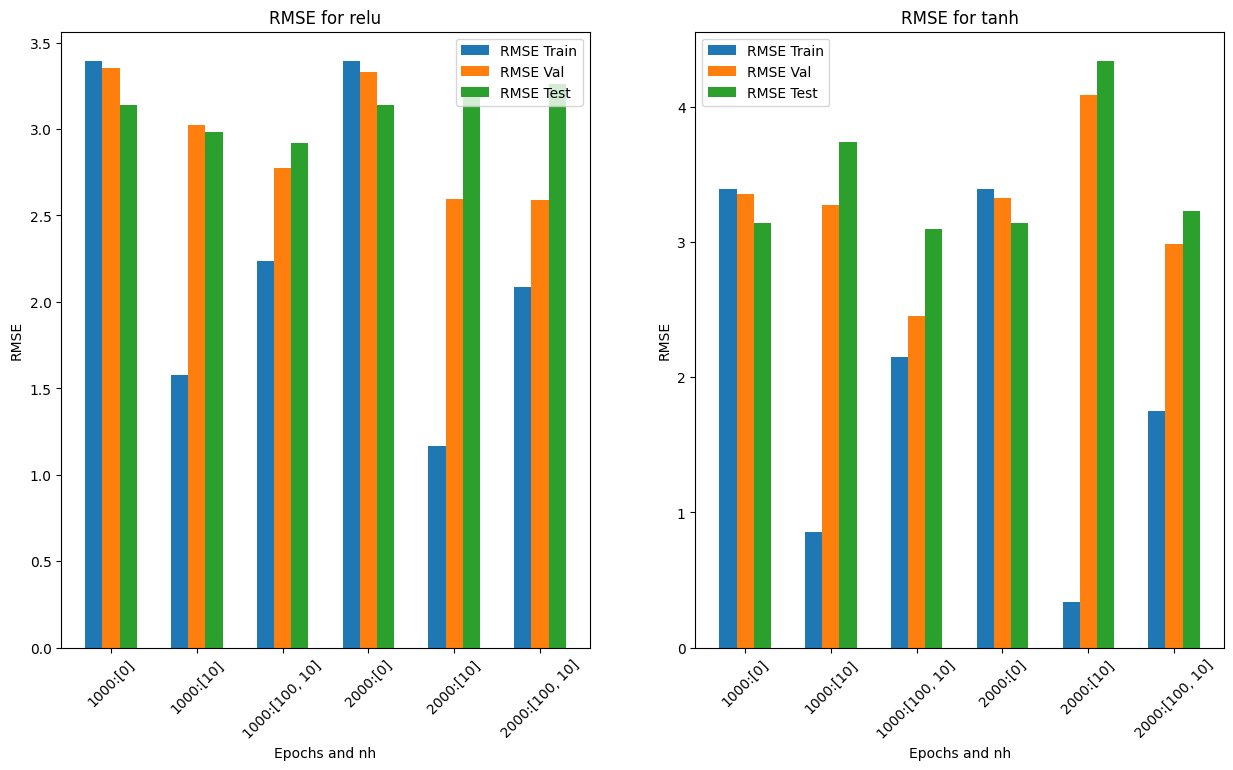

In [53]:
bar_width = 0.20
fig, axs = plt.subplots(1,2,figsize=(15,8))

#For relu
for i, col in enumerate(['RMSE Train', 'RMSE Val', 'RMSE Test']):
    axs[0].bar([pos + bar_width * i for pos in x], df_relu.groupby('epochs_nh')[col].mean(), width=bar_width, label=col)
axs[0].set_xlabel('Epochs and nh')
axs[0].set_ylabel('RMSE')
axs[0].set_title('RMSE for relu')
axs[0].set_xticks([pos + bar_width for pos in x])
axs[0].set_xticklabels(x_labels)
axs[0].legend()
axs[0].tick_params(axis='x', rotation=45)

#For tanh
#For relu
for i, col in enumerate(['RMSE Train', 'RMSE Val', 'RMSE Test']):
    axs[1].bar([pos + bar_width * i for pos in x], df_tanh.groupby('epochs_nh')[col].mean(), width=bar_width, label=col)
axs[1].set_xlabel('Epochs and nh')
axs[1].set_ylabel('RMSE')
axs[1].set_title('RMSE for tanh')
axs[1].set_xticks([pos + bar_width for pos in x])
axs[1].set_xticklabels(x_labels)
axs[1].legend()
axs[1].tick_params(axis='x', rotation=45)